In [1]:
import os
import torchvision as tv
import torch
from PIL import Image
from visdom import  Visdom
from torch import nn, optim
import numpy as np
import time
from torch.autograd import Variable

In [2]:
transform=tv.transforms.Compose([
    tv.transforms.Resize(64),
    tv.transforms.CenterCrop(64),
    tv.transforms.RandomHorizontalFlip(),
#     tv.transforms.RandomRotation(10),
    tv.transforms.ToTensor(),
#     tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5))
])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None,train=True,test=False):
        self.transform=transform
        self.test=test
        imgs=[os.path.join(root,img) for img in os.listdir(root)][:-1]
        imgs=sorted(imgs,key=lambda x: int(x.split('.')[-2]))[:20480]
        imgs_num=len(imgs)
        if self.test:
            self.imgs=imgs
        elif train:
            self.imgs=imgs[:int(0.8*imgs_num)]
        else:
            self.imgs=imgs[int(0.9*imgs_num):]
        
        
    def __getitem__(self,index):
        img_path=self.imgs[index]
        label=0 if 'dog' in img_path.split('/')[-1] else 1
        data=Image.open(img_path)
        if self.transform:
            data=self.transform(data)
        return data ,label
    
    def __len__(self):
        return len(self.imgs)
        

In [4]:
train_set=Dataset('./train',transform=transform,train=True)
val_set=Dataset('./train',transform=transform,train=False)
2560*8

20480

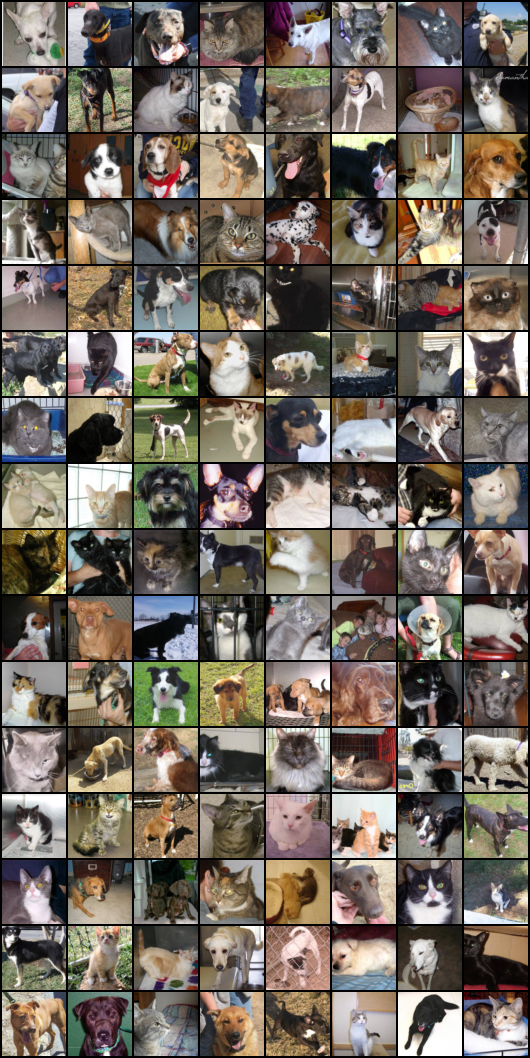

In [5]:
train_loader=torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True,num_workers=0)
val_loader=torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True,num_workers=0)
imgs,labels=next(iter(val_loader))
show=tv.transforms.ToPILImage()
img_grid=tv.utils.make_grid(imgs,nrow=8)
show(img_grid)

In [6]:
len(train_set),len(val_set)

(16384, 2048)

In [7]:
viz=Visdom(env='test')# python -m visdom.server

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "C:\Users\kevinoop\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connection.py", line 171, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\kevinoop\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\util\connection.py", line 79, in create_connection
    raise err
  File "C:\Users\kevinoop\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\util\connection.py", line 69, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] 由于目标计算机积极拒绝，无法连接。

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\kevinoop\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\kevinoop\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 354, in _make_request
    conn.request(method, ur

In [8]:
class ConvNet(nn.Module):

    def __init__(self, num_classes=2):
        
        super(ConvNet, self).__init__()

        self.features = nn.Sequential(  # 3*64*64
            nn.Conv2d(3, 64, kernel_size=5, padding=2), # 64*64*64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),# 64*32*32
            nn.Conv2d(64, 64, kernel_size=3, padding=1),# 64*32*32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),# 64*16*16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 128*16*16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),# 128*8*8
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# 256*8*8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),# 256*4*4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),# 512*4*4
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),# 512*4*4
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),# 512 * 4 * 4
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


__main__.ConvNet

In [9]:
model=ConvNet().to(device)
# model=model.cuda()
loss_f=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
# optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
model

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [10]:
# 起始时间设置
start_time = time.time()
# 可视化所需数据点
time_p, train_acc, loss_p, val_acc = [], [], [],[]
EPOCH=15

In [11]:
# 创建线图可视化窗口
line = viz.line(np.arange(10),win="line")
draw_epoch=16
for epoch in range(EPOCH):
    sum_loss, sum_tr_acc, sum_step, sum_val_acc,sum_val_step = 0., 0., 0.,0.,0.
    for i,(tx,ty) in enumerate(train_loader,1):        
        tx = tx.to(device)
        ty = ty.to(device)
        out=model(tx)
        loss=loss_f(out,ty)
        pred_tr=torch.max(out,1)[1]
        sum_loss+=loss.item()*ty.size(0)
        sum_tr_acc+=float((pred_tr==ty).sum())
        sum_step+=ty.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i% draw_epoch ==0:
            for _,(valx,valy) in enumerate(val_loader):
                valx=valx.to(device)
                valy=valy.to(device)
                val_out=model(valx)
                pred_val=torch.max(val_out,1)[1]
                sum_val_acc+=float((pred_val==valy).sum())
                sum_val_step+=valy.size(0)
            print("epoch:[{}/{}]|Loss:{:.4f} |Train_acc:{:.4f} |Val_acc:{:.4f}| Time:{:.1f}".format(epoch+1,EPOCH,
                                            sum_loss/sum_step,sum_tr_acc/sum_step,sum_val_acc/sum_val_step,time.time()-start_time))                

#             print("epoch:[{}/{}]|Loss:{:.4f} |Train_acc:{:.4f}| Time:{:.1f}".format(epoch+1,EPOCH,
#                                                 sum_loss/sum_step,sum_tr_acc/sum_step,time.time()-start_time))            
            if epoch!=0|i>draw_epoch:
                time_p.append(time.time()-start_time)
                train_acc.append(sum_tr_acc/sum_step)
                val_acc.append(sum_val_acc/sum_val_step)
                loss_p.append(sum_loss/sum_step)
#                     viz.line(X=np.column_stack((np.array(time_p), np.array(time_p))),
#                             Y=np.column_stack((np.array(loss_p), np.array(train_acc))),
#                              win="line",
#                              opts=dict(legend=["Loss", "TRAIN_acc"]))
                viz.line(X=np.column_stack((np.array(time_p), np.array(time_p), np.array(time_p))),
                            Y=np.column_stack((np.array(loss_p), np.array(train_acc), np.array(val_acc))),
                            win="line",
                            opts=dict(legend=["Loss", "TRAIN_acc", "Val_acc"]))
    
            sum_loss, sum_tr_acc, sum_step, sum_val_acc,sum_val_step = 0., 0., 0.,0.,0.
print('finish')

epoch:[1/15]|Loss:0.7805 |Train_acc:0.5210 |Val_acc:0.5327| Time:11.7
epoch:[1/15]|Loss:0.6912 |Train_acc:0.5615 |Val_acc:0.5601| Time:22.4
epoch:[1/15]|Loss:0.6688 |Train_acc:0.6011 |Val_acc:0.6230| Time:33.1
epoch:[1/15]|Loss:0.6529 |Train_acc:0.6372 |Val_acc:0.6758| Time:43.8
epoch:[1/15]|Loss:0.6249 |Train_acc:0.6626 |Val_acc:0.6831| Time:54.4
epoch:[1/15]|Loss:0.5972 |Train_acc:0.6860 |Val_acc:0.7002| Time:65.1
epoch:[1/15]|Loss:0.5914 |Train_acc:0.7168 |Val_acc:0.7134| Time:75.7
epoch:[1/15]|Loss:0.5884 |Train_acc:0.7134 |Val_acc:0.7212| Time:86.4
epoch:[2/15]|Loss:0.5542 |Train_acc:0.7261 |Val_acc:0.7295| Time:96.9
epoch:[2/15]|Loss:0.5430 |Train_acc:0.7251 |Val_acc:0.7515| Time:107.6
epoch:[2/15]|Loss:0.5350 |Train_acc:0.7363 |Val_acc:0.7290| Time:118.3
epoch:[2/15]|Loss:0.5123 |Train_acc:0.7646 |Val_acc:0.7539| Time:128.9
epoch:[2/15]|Loss:0.5181 |Train_acc:0.7559 |Val_acc:0.7769| Time:139.7
epoch:[2/15]|Loss:0.5010 |Train_acc:0.7725 |Val_acc:0.7417| Time:150.3
epoch:[2/15]|Lo